In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import data
titanic = pd.read_csv('http://collaboratescience.com/cheatsheets/titanic.csv')

In [3]:
# Drop body and cabin since more than 50% of the data is missing
titanic.drop(['cabin', 'body'], axis = 1, inplace = True)

In [4]:
# Drop boat, home.dest and use complete case analysis to drop rows with missing data
titanic.drop(['boat', 'home.dest'], axis = 1, inplace = True)
titanic.dropna(inplace = True)

In [5]:
# Create a new column FamilyCount which is the sum of SibSp and Parch
titanic["family_count"] = titanic['sibsp'] + titanic['parch']

In [6]:
# Create a title column using RegEx from the name
title  =  titanic['name'].str.extract(r', ([^\.]+)\.')
titanic['title'] = title

/Users/seanmcclure/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [7]:
# Take the log of fare to make it more normally distributed 
titanic['fare'] = titanic['fare'].map(lambda x: np.log1p(x))

In [8]:
# One hot encode categorical values
titanic = pd.get_dummies(titanic, columns = ['embarked', 'sex', 'title'], drop_first = True)

In [9]:
# Define features and target in train data
X = titanic.drop(['name', 'ticket', 'survived'], axis = 1)
y = titanic['survived']

In [10]:
# Standardize the predictors in X
ss = StandardScaler()
ss.fit(X) 
X_scaled = ss.transform(X)

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y , test_size = 0.3)

In [12]:
# Gridsearch on logistic regression model 
lr_params = {'penalty':['l1', 'l2'], 
             'C': np.logspace(-5, 2, 10)}
gs = GridSearchCV(LogisticRegression(), param_grid = lr_params)
gs.fit(X_train, y_train)

# Results 
gs.best_score_, gs.best_params_

(0.8082191780821918, {'C': 2.782559402207126, 'penalty': 'l1'})

In [13]:
# Gridsearch test accuracy score
gs.score(X_test, y_test)

0.8115015974440895

In [14]:
# Evaluate gridsearched model with AUC-ROC score
y_score = gs.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score)

0.8487182751888633

In [15]:
# Determine top predictors in model 
coefs = pd.DataFrame(gs.best_estimator_.coef_[0], index = X.columns, columns = ['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head()

,coef
title_Master,0.492839
title_Dr,0.217930
title_Mrs,0.214870
title_Sir,0.166776
title_the Countess,0.075845


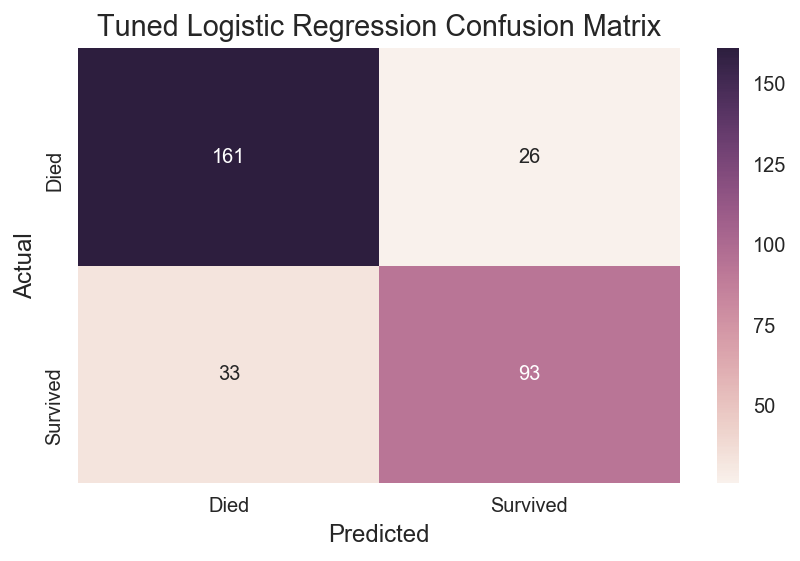

In [16]:
# Create a heatmap confusion matrix - get predictions 
predictions = gs.predict(X_test)

# Create confusion matrix 
classes = ["Died", 'Survived']
cm = metrics.confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, columns=classes)
cm.index = classes

# Plot matrix on heatmap 
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Tuned Logistic Regression Confusion Matrix');

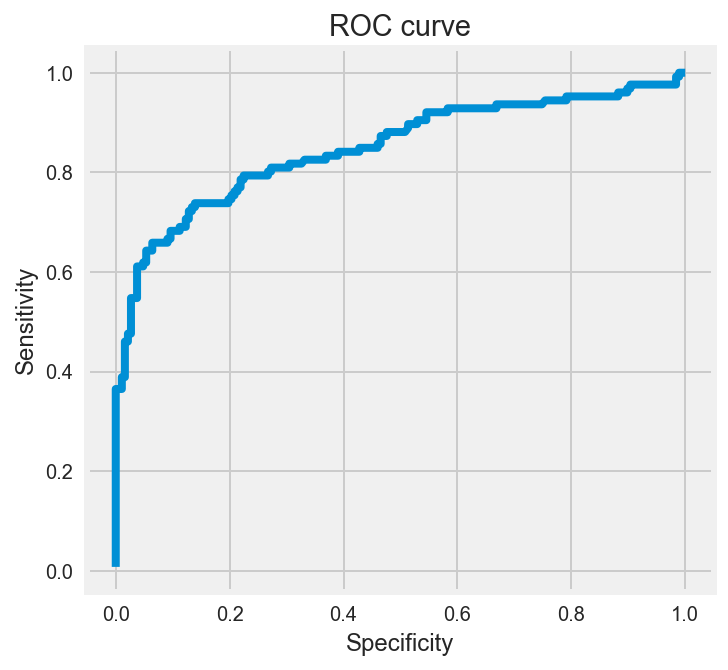

In [17]:
# ROC Plot 
y_probs = gs.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve');